## Alessandro Bianchetti

## Exercise 7

Consider a bivariate Gaussian distribution N($\mu$,$\Sigma$), where $\mu$ = (4, 2),
$\Sigma_{11}$ = 1.44, $\Sigma_{22}$ = 0.81, $\Sigma_{12}$ = $\Sigma_{12}$ = −0.702. Assume that such distribution
describes the posterior of two parameters $X_1$ and $X_2$. Plot contours
of this distribution and tell what are the boundaries of the 95\% credibile
interval for each parameter, after marginalizing over the other. Tell how
these boundaries change if, instead of marginalizing, we fix either parameter
to a known value. Now, re-obtain the same boundaries via Monte
Carlo sampling of the posterior, in three ways: a) by directly drawing values
of ($X_1$,$X_2$), by mean of a a Cholesky decomposition of the covariance
(check in the literature how to do this); b) Via Metropolis-Hastings sampling
of the posterior, c) Via Gibbs sampling of the posterior. In all cases,
do not rely on pre-made code, but write your own (i.e., you can surely
use libraries to generate known distributions, do Cholesky decomposition,
and so on, but you should not use a pre-made library with a command like
”Gibbs-sampling”). In all cases, provide final contour plots, and marginalized
posteriors. In the MCMC analysis, produce also trace plots to test
for convergence of the chains. 

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from numpy.random import random, seed
from scipy.stats import multivariate_normal as mvn
import scipy.integrate as integrate

%matplotlib inline

## Part 0: plotting the distribution
In order to make notation  easier, we're going re-name the parameters $X_1$ and $X_2$ as X and Y, especially as long as code chunks are concerned. 

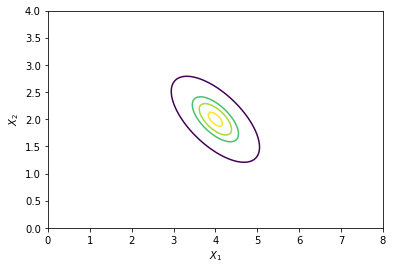

In [39]:
D = int(2)
x = np.random.rand(D)
mu = np.array([4,2],float)
cov = np.array([[1.44,-0.702],[-0.702,0.81]])
det = cov[0,0]*cov[1,1]-cov[0,1]**2
prec = np.linalg.inv(cov)


x, y = np.meshgrid(np.linspace(0,8,100),np.linspace(0,4,100))
xy = np.column_stack([x.flat, y.flat])
z = mvn.pdf(xy, mu, cov).reshape(x.shape)

# arbitrary contour levels, of course here the numbers are just symbolic and they have nothing to do with credibility intervals
max = 0.19371
contour_level = [0.68*max,0.9*max,0.95*max,0.99*max]

fig = plt.contour(x, y, z, levels = contour_level)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.show()

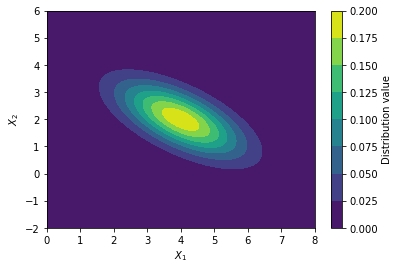

In [40]:
N = int(1e3)
xvec = np.linspace(0,8,N)
yvec = np.linspace(-2,6,N)
x, y = np.meshgrid(xvec,yvec)
xy = np.dstack((x, y))
rv = mvn(mu, cov)
z = rv.pdf(xy)

cs = plt.contourf(x, y, z, cmap="viridis")
cbar = plt.colorbar(cs, orientation="vertical", label="Distribution value")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")

plt.tight_layout
plt.show()

In [41]:
#useful functions

# a one-dimensional gaussian
def gaussian(x,any_mean,any_sigma):
    c = 1./np.sqrt(any_sigma)*1/(2*np.pi)**0.5*np.e**(-0.5*(x-any_mean)**2/any_sigma)
    return c


# a function to compute credibility intervals exploiting scipy.quad
alpha = 0.95
eps=1e-4

def find_95(any_mean,any_sigma):
    interval_y = [any_mean-eps, any_mean+eps]
    I=[0,0]

    while(I[0]<alpha): 
        I = integrate.quad(gaussian, interval_y[0], interval_y[1], epsrel=1.e-5, args=(any_mean,any_sigma))
        interval_y[0] -= eps
        interval_y[1] += eps
        
    return interval_y

## Part 1: marginalization
We marginalize the original BVN over X to get the posterior for Y. The marginalization process over a MVN is known to yield another MVN with the untouched mean component of the non-marginalised variables, whilst affecting the variance. In our case, we have a univariate normal distribution with mean $\mu_y$ and variance $C_{yy}$, ie by the corresponding submatrix of the covariance matrix, in our case it is just a scalar. If we label $C^{-1}=V$ as the precision matrix, we can write the marginalised posterior as
$$
UVN(y) = \mathcal{N}(y|\mu_y, (V_{yy}-V_{xy}V_{xx}^{-1}V_{xy})^{-1}) = \mathcal{N}(y|\mu_y, C_{yy})
$$
We can perform the integration in two different ways. First, we use scipy.quad to loop over that integral until we find the correct interval. 


In [42]:
N = int(1000)
mean = mu[1]
sigma = cov[1,1]

cred_interval = find_95(mean,sigma)
print("X2 credibility interval:    ", cred_interval)


X2 credibility interval:     [0.2359000000001943, 3.764100000003723]


We now marginalize over Y, thus getting the posterior for X and extracting the credibility interval in X. This time the marginalized posterior is
$$
UVN(x) = \mathcal{N}(x|\mu_x,C_{xx})
$$

In [43]:
mean = mu[0]
sigma = cov[0,0]

cred_interval = find_95(mean,sigma)
print("X1 credibility interval:    ", cred_interval)

X1 credibility interval:     [1.6478999999958184, 6.352099999994518]


In this simple 2D case, we quickly obtained the marginalized posterior by working with a scalar variance. But as dimensions grow, finding the analytical expression for the new covariance can become costly. An alternative path for the marginalization integral could be graphical: projecting the above 2D histogram on either axis is the exact way to visualize the marginalization process. After projection, we get a univariate Gaussian, for which we can calculate the credibility interval. We do this for $X_2$ (or y), then for $X_1$ (or x).

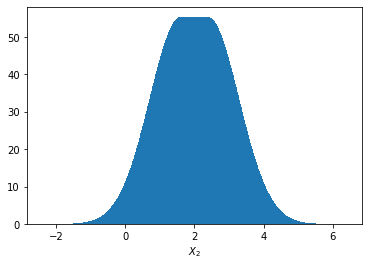

Credibility interval:    [ 0.23423423423423406 , 3.7737737737737733 ]


In [48]:
marg_post_y = np.zeros(N, float)
for i in range(N):
    for j in range(N):
        marg_post_y[i] += z[i,j]

plt.bar(yvec,marg_post_y)
plt.xlabel("$X_2$")
plt.show()

bin_width = (yvec[-1]-yvec[0])/N
I = sum(marg_post_y)*bin_width
#print(I)   we have to permorm the total integral because it is unnormalised
alpha = 0.95*I

ind = int(N/2)

ind1 = ind-1
ind2 = ind+1
I0=0
while(I0<alpha): 
    I0=0
    for j in range(ind1,ind2):
        I0 += marg_post_y[j]*bin_width
    ind1 -=1
    ind2 +=1
    

print("Credibility interval:    [", yvec[ind1],",", yvec[ind2],"]")
    

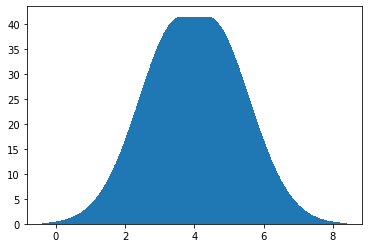

Credibility interval:    [ 1.6496496496496496 , 6.358358358358358 ]


In [50]:
marg_post_x = np.zeros(N, float)
for i in range(N):
    for j in range(N):
        marg_post_x[i] += z[j,i]

plt.bar(xvec,marg_post_x)
plt.show()

bin_width = (xvec[-1]-xvec[0])/N
I = sum(marg_post_x)*bin_width
alpha = 0.95*I 

ind = int(N/2)

ind1 = ind-1
ind2 = ind+1
I0=0
while(I0<alpha): 
    I0=0
    for j in range(ind1,ind2):
        I0 += marg_post_x[j]*bin_width
    ind1 -=1
    ind2 +=1
    

print("Credibility interval:    [",xvec[ind1],",",xvec[ind2],"]")
        

We're happy to notice that both methods produce the same credibility intervals on the two parameters.

In [52]:
# for some reason I don't understand I have to re-run this cell with the function before going on with conditioning, otherwise the rest of the notebook won't run properly

alpha = 0.95
eps=1e-4

def find_95(any_mean,any_sigma):
    interval_y = [any_mean-eps, any_mean+eps]
    I=[0,0]

    while(I[0]<alpha): 
        I = integrate.quad(gaussian, interval_y[0], interval_y[1], epsrel=1.e-5, args=(any_mean,any_sigma))
        interval_y[0] -= eps
        interval_y[1] += eps
        #print(interval_y)
        
    return interval_y

## Part 2: conditioning

Next step is computing the credibility interval after fixing either parameter, instead of marginalizing over it. We take the BVN and just fix both parameters, one at a time, to their correspondent mean value. Conditioning produces another MVN with unchanged covariance, but new mean. A conditioned BVN (fixed y) becomes the following UVN(x)
$$
UVN(x) = \mathcal{N}(x|\mu_x-V_{xx}^{-1}V_{xy}(y-\mu_y),V_{xx}^{-1})
$$

In [53]:
# check the form of the conditioning

sigma_cond_x = 1./np.sqrt(prec[0,0])
y_sample = np.random.normal(loc=mu[1], scale=cov[1,1],size=20)
y = sum(y_sample)/len(y_sample)
mean_cond_x = mu[0]-prec[0,1]/prec[0,0]*(y-mu[1])      #fixing y to its mean cancels the extra term. Watch out, fixing the parameter influences the obtained interval
print("Conditioned mean:    ", mean_cond_x)

#interval_x = [-1000, 1000]
#Itot = integrate.quad(gaussian, interval_x[0], interval_x[1], epsrel=1.e-7,args=(mean,sigma))
#print(Itot)
#alpha = Itot[0]*0.95


cred_interval_cond_x = find_95(mean_cond_x,sigma_cond_x)
print("Credibility interval:    ", cred_interval_cond_x)

Conditioned mean:     4.050175016252236
Credibility interval:     [2.1783750162485087, 5.921975016247874]


In [54]:
sigma_cond_y = 1./np.sqrt(prec[1,1])
x_sample = np.random.normal(loc=mu[0], scale=cov[0,0],size=20)
x = sum(x_sample)/len(x_sample)
mean_cond_y = mu[1]-prec[0,1]/prec[1,1]*(x-mu[0])      #fixing y to its mean cancels the extra term. Watch out, fixing the parameter influences the obtained interval
print("Conditioned mean:    ", mean_cond_y)

#interval_x = [-1000, 1000]
#Itot = integrate.quad(gaussian, interval_x[0], interval_x[1], epsrel=1.e-7,args=(mean,sigma))
#print(Itot)
#alpha = Itot[0]*0.95


cred_interval_y = find_95(mean_cond_y,sigma_cond_y)
print("Credibility interval:    ", cred_interval_y)

Conditioned mean:     1.710775219464806
Credibility interval:     [0.08967521946497967, 3.3318752194675847]


The credibility intervals are different with respect to the marginalization case. First of all, we're treating a physical situation in which we assume we know part of the parameters (nuisance parameters) and we're fixing them to a given value. In the above code, we fixed either x or y to a random value. The obtained credibility interval depends on the fixed variable too, since every new random generation produces a new credibility interval. As a final result, the credibility interval are now centered on another value (the conditioned mean) and are a little narrower.

In [55]:
#define a function to integrate over a histogram
def cred_interval_hist(nfreq,bins):
    nbins = int(100)
    s = 0
    for i in range(len(nfreq)):
        s += nfreq[i] * ((bins[i] + bins[i+1]) / 2) 
    mean = s / np.sum(nfreq)
    print("Mean value:  ", mean)

    bin_width = (bins[-1]-bins[0])/nbins
    #print(bin_width_y)
    I = bin_width * sum(nfreq[0:99])
    #print(Iy)
    alpha = 0.95*I

    bin_mean = int((mean-bins[0])/bin_width)
    print("Bin hosting the mean value:  ",bin_mean)
    bin1 = bin_mean-1
    bin2 = bin_mean+1
    I=0
    while(I<alpha): 
        I=0
        I = bin_width * sum(nfreq[bin1:bin2])
        bin1 -= 1
        bin2 += 1
        
    print("Credibility interval:    [", bins[0]+bin1*bin_width,",",bins[0]+bin2*bin_width,"]")
    

## Part 3: Cholesky decomposition

A Gaussian distribution can be generated by applying a Cholesky decomposition of the covariance. In a nutshell, Cholesky decomposition means to decompose a positive definite matrix into the product of a lower triangular matrix $L$ and its transpose, such that $\Sigma = L^T L$. After this, we can generate a set of variables following the standard Gaussian distribution $\mathcal{N}(\vec{r}|\vec{0}, \mathcal{1}_2)$. If we now define $\vec{v} = L\vec{r}+\mu$, it can be proven that $\vec{v} \in \mathcal{N}(\vec{v}|\mu, \Sigma)$.

In [56]:
L = np.linalg.cholesky(cov) # Cholesky decompositionplt.figure(figsize = (12, 6))

r = np.random.normal(loc=0.0, scale=1.0, size=(int(1e5),2))
v = []
for item in r:
    v.append(np.dot(L,item)+mu)

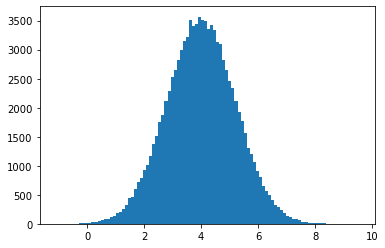

Mean value:   3.9948132608513998
Bin hosting the mean value:   48
Credibility interval:    [ 1.4316883931775846 , 6.5550967716286666 ]


In [57]:
X = []
Y = []
for item in v:
    X.append(item[0])
    Y.append(item[1])

nbins=int(100)
nx, binsx, _ = plt.hist(X,bins=nbins)
plt.show()

cred_interval_hist(nx,binsx)

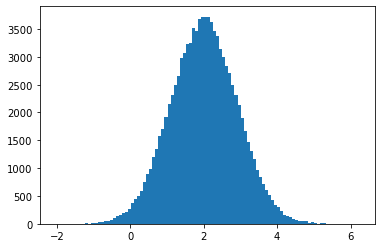

Mean value:   2.0028443819791173
Bin hosting the mean value:   48
Credibility interval:    [ 0.020794028779782536 , 3.832703423902233 ]


In [58]:
ny, binsy, _ = plt.hist(Y,bins=nbins)
plt.show()

cred_interval_hist(ny,binsy)

## Part 4: Metropoli-Hastings

Now we try out the Metropoli-Hastings method to sample the BVN. We need to define a new distribution Q, possibly symmetric like a MVN, and draw from it. An acceptance step is then considered, to check whether or not the next sample is validated.

In [59]:
from tqdm.notebook import tqdm

In [60]:
#define Q
def gauss_2d(mean, sigmax, sigmay):
    a = np.random.normal(loc=mean[0], scale=sigmax, size=1)
    b = np.random.normal(loc=mean[1], scale=sigmay, size=1)
    return list(map(list, zip(a, b)))[0]

#define acceptance rate
def acceptance(next, curr):
    prob_next = mvn.pdf(next,mu,cov)
    prob_curr = mvn.pdf(curr,mu,cov)
    alpha = min(prob_next/prob_curr,1)
    return alpha

def random_coin(p):
    k = np.random.uniform(0,1)
    if k>=p:
        return False
    else:
        return True

N=int(1e4)

def MVN(r):
    c = 1./(2*np.pi)*1./np.sqrt(det)*np.e**(-0.5*np.dot((r-mu), np.dot(prec, (r-mu))))
    return c

def MH(start_point):
    with tqdm(total=N) as pbar:
        r = start_point
        fin = []
        Tr = 0.
        trace = []
        while(len(fin)<N):
            fin.append(r)
            rplus = gauss_2d(r,1.5,1.0)
            Tr -= np.log(MVN(rplus))/len(fin)
            trace.append(Tr)
            alpha = acceptance(rplus,r)
            bool = random_coin(alpha)
            if(bool):
                r = rplus
            pbar.update(1)
    fin = np.array(fin)
    trace = np.array(trace)   
    return fin, trace 

def plot_gauss(fin,start_point):
    xtry = []
    for i in range(int(len(fin))):
        xtry.append(fin[i][0])
    ytry = []
    for i in range(int(len(fin))):
        ytry.append(fin[i][1])

    plt.hist2d(xtry,ytry,bins=(25,25))
    plt.title("Generated Gaussian profile: starting point " + str(start_point))

    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,4))
    nx, binsx, _  = ax1.hist(xtry,bins=100)
    ax1.set_title('Distribution projected on x')
    ny, binsy, _ = ax2.hist(ytry,bins=100)
    ax2.set_title('Distribution projected on y')
    plt.show()

    plt.tight_layout
    plt.show()


    cred_interval_hist(nx,binsx)
    cred_interval_hist(ny,binsy)


  0%|          | 0/10000 [00:00<?, ?it/s]

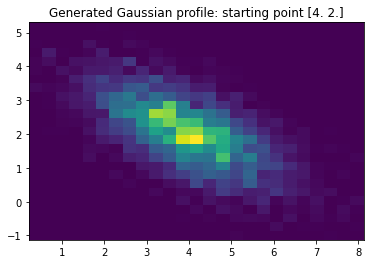

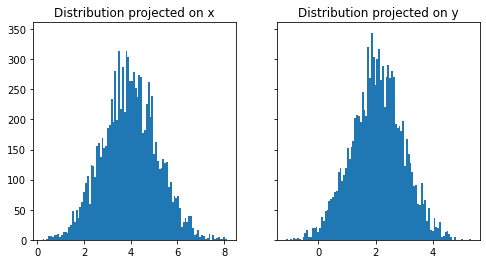

Mean value:   3.960025204161899
Bin hosting the mean value:   47
Credibility interval:    [ 1.4888825027692922 , 6.387256354157707 ]
Mean value:   2.0551730307086444
Bin hosting the mean value:   49
Credibility interval:    [ 0.1581927186907086 , 3.8882156055860397 ]


In [61]:
fin1, trace1 = MH(mu)
plot_gauss(fin1,mu)

Looking at the projected 1D plots and the 2D contour, the algorithm worked correctly. We now generated three more chains, in order to estimate variance and perfrom the Gelman-Rubin test.

  0%|          | 0/10000 [00:00<?, ?it/s]

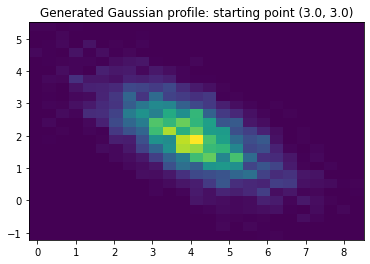

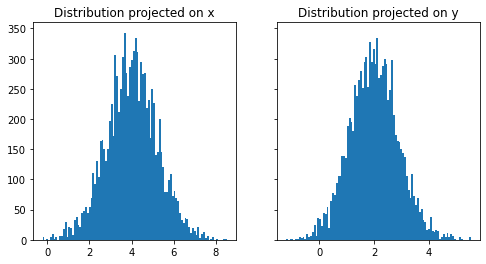

Mean value:   4.005352140426536
Bin hosting the mean value:   48
Credibility interval:    [ 1.440798237171589 , 6.5095356334513035 ]
Mean value:   1.9933900376740734
Bin hosting the mean value:   47
Credibility interval:    [ 0.06072626772375256 , 3.82802335554627 ]
#############################################################################


  0%|          | 0/10000 [00:00<?, ?it/s]

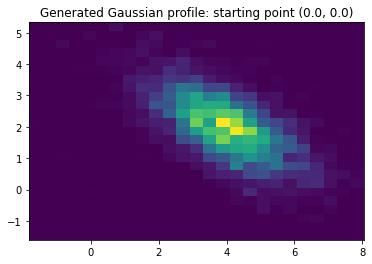

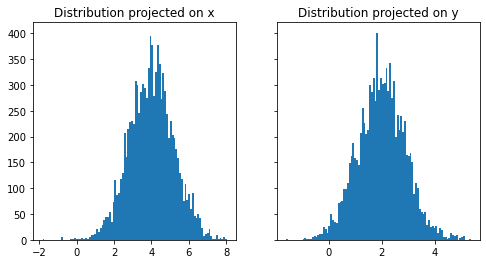

Mean value:   4.001539196744591
Bin hosting the mean value:   59
Credibility interval:    [ 1.535390989787006 , 6.462563144661106 ]
Mean value:   1.9865938991582246
Bin hosting the mean value:   51
Credibility interval:    [ 0.06160185029962695 , 3.8042549734517586 ]
#############################################################################


  0%|          | 0/10000 [00:00<?, ?it/s]

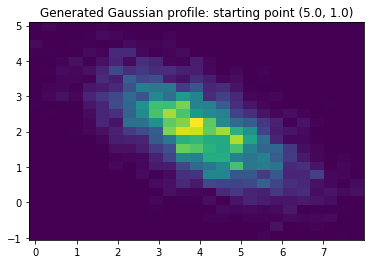

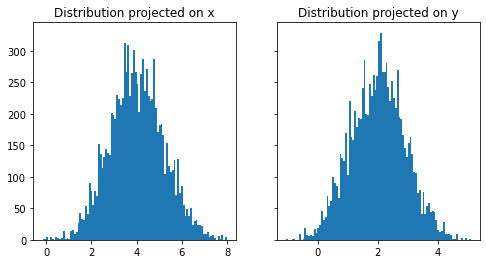

Mean value:   4.008651049770986
Bin hosting the mean value:   51
Credibility interval:    [ 1.552380327067556 , 6.4431091220488 ]
Mean value:   2.0082400925987045
Bin hosting the mean value:   49
Credibility interval:    [ 0.10877453779295987 , 3.7984661769413934 ]
#############################################################################


In [62]:
r = (3.,3.)
fin2, trace2 = MH(r)
plot_gauss(fin2, r)
print("#############################################################################")

r = (0.,0.)
fin3, trace3 = MH(r)
plot_gauss(fin3, r)
print("#############################################################################")


r = (5.,1.)
fin4, trace4 = MH(r)
plot_gauss(fin4, r)
print("#############################################################################")

Let's first check if the chains converged correctly.

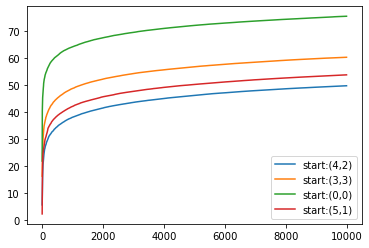

In [63]:
mvec = np.linspace(1,len(fin1),len(fin1))
plt.plot(mvec, trace1, label="start:(4,2)")
plt.plot(mvec, trace2, label="start:(3,3)")
plt.plot(mvec, trace3, label="start:(0,0)")
plt.plot(mvec, trace4, label="start:(5,1)")
plt.legend()
plt.show()

In [64]:
burnin = int(0.4*len(fin1))
fin1 = fin1[burnin:]
fin2 = fin2[burnin:]
fin3 = fin3[burnin:]
fin4 = fin4[burnin:]

Let's perform the Gelman-Rubin test for the variance

In [65]:
av1 = sum(fin1)/int(len(fin1))
av2 = sum(fin2)/int(len(fin2))
av3 = sum(fin3)/int(len(fin3))
av4 = sum(fin4)/int(len(fin4))
av_tot = sum

av_theta = np.array([av1,av2,av3,av4])   # array of the averages, each component is the mean of a chain
#print(av_theta)

av_tot = sum(av_theta)/4
print("Total average between chains:   ", av_tot)

Total average between chains:    [4.00420993 2.01704412]


In [66]:
def chain_var(vec,mean):
    s = 0.
    for i in range(int(len(vec))):
        s += np.outer(vec[i]-av1,vec[i]-av1)
    s /= (len(fin1)-1)
    return s

var = np.array([chain_var(fin1,av1),chain_var(fin2,av2),chain_var(fin3,av3),chain_var(fin4,av4)])
av_var = sum(var)/4
#print(av_var)

z = 0.
for j in range(4):
    z += np.outer(av_theta[j]-av_tot,av_theta[j]-av_tot)

z /= 3.
#print(z)

final_var = (len(fin1)-1)/len(fin1)*av_var + z
print("Estimated variance:  ","\n", final_var)

#Gelman Rubin test
R = final_var/av_var 
R_ratio = sum(sum(R))/4
print("R=",R_ratio)


Estimated variance:   
 [[ 1.45865375 -0.7248289 ]
 [-0.7248289   0.8469911 ]]
R= 1.00403191373084


The final value for R is very close to 1, thus proving that we have reached a nice estimate for the variance, in terms of both achiedved convergence and good mixing.

## Part 5: Gibbs sampling

We now try to sample the Gaussian distribution by using GIbbs sampling. It's basically a MH, but the movement probabilities now change. We choose a component of the starting point (x,y) and fix it, then evolve the other component by sampling from the conditioned probability, given that the other is fixed. 

In [67]:
N=int(1e4)
def GS(start_point):
    r = start_point
    fin = []
    Tr = 0.
    trace = []
    prec = np.linalg.inv(cov)
    while(len(fin)<N):
        fin.append(r)
        k = int(np.random.uniform(0.,1.)+0.5)
        l = int(abs(k-1))
        sigma = 1./np.sqrt(prec[k,k])
        mean = mu[k]-prec[k,l]/prec[k,k]*(r[l]-mu[l])
        q = np.random.normal(mean,sigma)
        rplus = np.zeros(2,float)
        rplus[k] = q
        rplus[l] = r[l]
        r = rplus
        Tr -= np.log(MVN(r))/len(fin)
        trace.append(Tr)
    fin = np.array(fin)
    trace = np.array(trace)
    return fin, trace


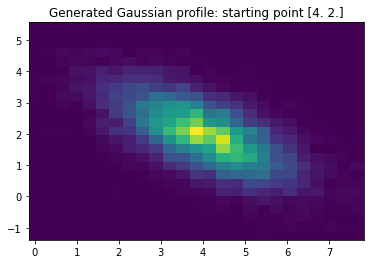

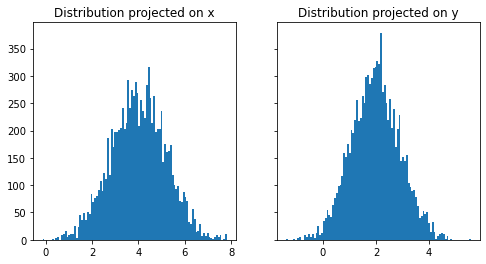

Mean value:   4.0109303991430485
Bin hosting the mean value:   52
Credibility interval:    [ 1.6159163639869 , 6.3885878191074035 ]
Mean value:   1.9835558636235742
Bin hosting the mean value:   48
Credibility interval:    [ 0.07367401068574342 , 3.8241102089119723 ]


In [68]:
fin1, trace1 = GS(mu)
plot_gauss(fin1, mu)

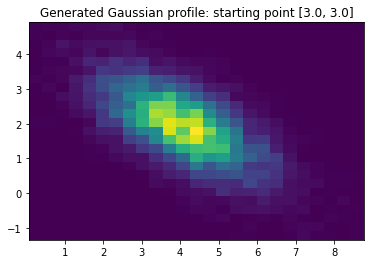

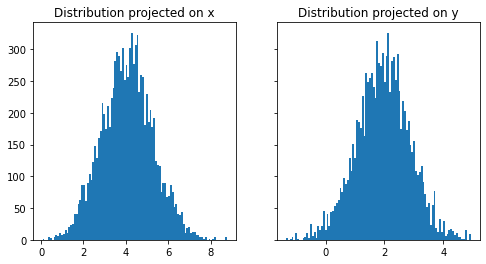

Mean value:   4.059823591805282
Bin hosting the mean value:   45
Credibility interval:    [ 1.461405725242288 , 6.50535753958191 ]
Mean value:   1.9515696407853385
Bin hosting the mean value:   52
Credibility interval:    [ 0.03507820230966563 , 3.796063288101994 ]
#############################################################################


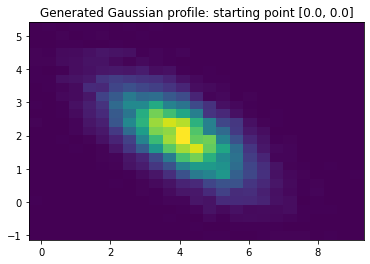

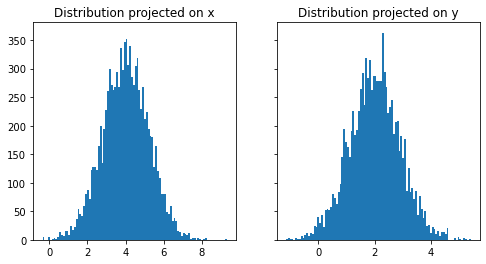

Mean value:   4.000650463136426
Bin hosting the mean value:   45
Credibility interval:    [ 1.4820546731507227 , 6.517154750013284 ]
Mean value:   2.006378985580447
Bin hosting the mean value:   48
Credibility interval:    [ 0.10226416536142513 , 3.90219946426772 ]
#############################################################################


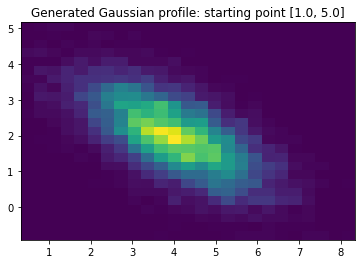

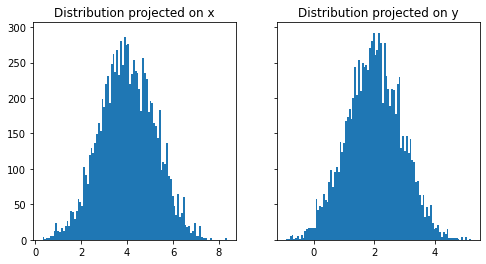

Mean value:   4.007944168521842
Bin hosting the mean value:   45
Credibility interval:    [ 1.5197557312239813 , 6.343041515041337 ]
Mean value:   1.9903580084075267
Bin hosting the mean value:   47
Credibility interval:    [ 0.0604668565235823 , 3.8259659223906324 ]


In [69]:
r = [3.,3.]
fin2, trace2 = GS(r)
plot_gauss(fin2, r)
print("#############################################################################")

r = [0.,0.]
fin3, trace3 = GS(r)
plot_gauss(fin3, r)
print("#############################################################################")

r = [1.,5.]
fin4, trace4 = GS(r)
plot_gauss(fin4, r)

As in the previous case, we run convergence test and GR test.

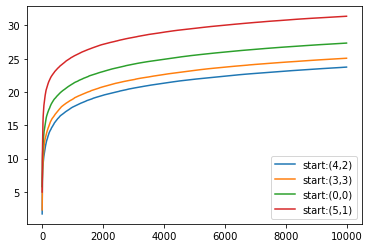

In [70]:
mvec = np.linspace(1,len(fin1),len(fin1))
plt.plot(mvec, trace1, label="start:(4,2)")
plt.plot(mvec, trace2, label="start:(3,3)")
plt.plot(mvec, trace3, label="start:(0,0)")
plt.plot(mvec, trace4, label="start:(5,1)")
plt.legend()
plt.show()

In [71]:
burnin = int(0.2*len(fin1))
fin1 = fin1[burnin:]
fin2 = fin2[burnin:]
fin3 = fin3[burnin:]
fin4 = fin4[burnin:]


In [72]:
av1 = sum(fin1)/int(len(fin1))
av2 = sum(fin2)/int(len(fin2))
av3 = sum(fin3)/int(len(fin3))
av4 = sum(fin4)/int(len(fin4))
av_tot = sum

av_theta = np.array([av1,av2,av3,av4])   # array of the averages, each component is the mean of a chain
#print(av_theta)

av_tot = sum(av_theta)/4
print("Total average:   ", av_tot)

def chain_var(vec,mean):
    s = 0.
    for i in range(int(len(vec))):
        s += np.outer(vec[i]-av1,vec[i]-av1)
    s /= (len(fin1)-1)
    return s

var = np.array([chain_var(fin1,av1),chain_var(fin2,av2),chain_var(fin3,av3),chain_var(fin4,av4)])
av_var = sum(var)/4
#print(av_var)

z = 0.
for j in range(4):
    z += np.outer(av_theta[j]-av_tot,av_theta[j]-av_tot)

z /= 3.
#print(z)

final_var = (len(fin1)-1)/len(fin1)*av_var + z
print("Estimated variance:  ","\n", final_var)

#Gelman Rubin test
R = final_var/av_var 
R_ratio = sum(sum(R))/4
print("R=",R_ratio)

Total average:    [4.02430454 1.97995768]
Estimated variance:   
 [[ 1.42693432 -0.70271151]
 [-0.70271151  0.81776654]]
R= 1.0016924823744981
